# Dynamic RNN Make Pratical

Modify from this [notebook](https://www.kaggle.com/winternguyen/predict-household-electric-power-using-lstms)

# Introduction:

In this Notebook, I try to learn and build the Long Short-Term Memory (LSTM) recurrent neural network to fit one third of data and then predict the rest of data.
    
Database information:
    
(1) date: Date in format dd/mm/yyyy

(2) time: time in format hh:mm:ss

(3) global_active_power: household global minute-averaged active power (in kilowatt)

(4) global_reactive_power: household global minute-averaged reactive power (in kilowatt)

(5) voltage: minute-averaged voltage (in volt)

(6) global_intensity: household global minute-averaged current intensity (in ampere)

(7) sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

(8) sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

(9) sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/home/ccchen/sychou/dynamic_RNN/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/ccchen/sychou/dynamic_RNN/dataset/household_power_consumption.txt


# Step 1: Import & cleaning data

Importing the txt file takes more time than that of csv file.

In [2]:
df = pd.read_csv('/home/ccchen/sychou/dynamic_RNN/dataset/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
df.shape

(2075259, 7)

This database have 2,075,259 rows and 7 columns. Let's check the NA data and fill na data with the mean values.

In [4]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
df = df.fillna(df.mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# Step 2: Data visualizations

In [6]:
# import matplotlib.pyplot as plt

# i = 1
# cols=[0, 1, 3, 4, 5, 6]
# plt.figure(figsize=(20, 10))
# for col in cols:
#     plt.subplot(len(cols), 1, i)
#     plt.plot(df.resample('M').mean().values[:, col])
#     plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
#     i += 1
# plt.show()

In [7]:
# i = 1
# cols=[0, 1, 3, 4, 5, 6]
# plt.figure(figsize=(20, 10))
# for col in cols:
#     plt.subplot(len(cols), 1, i)
#     plt.plot(df.resample('D').mean().values[:, col])
#     plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
#     i += 1
# plt.show()

In [8]:
# i = 1
# cols=[0, 1, 3, 4, 5, 6]
# plt.figure(figsize=(20, 10))
# for col in cols:
#     plt.subplot(len(cols), 1, i)
#     plt.plot(df.resample('H').mean().values[:, col])
#     plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
#     i += 1
# plt.show()

# From above visualizations:

+ the resampling by month, date or hour is very important because it has a large interaction as expected (changing the periodicity of the system). 
+ Therefore, if processing all the original data, the runtime will be very costly, but if processing data with large time-scale samples (e.g. monthly), it will affect the model's predictivity. 
+ From observation, we can see, it is relatively reasonable to resample data by hour.

In [9]:
# df.corr()

From above table, it is seen that 'Global_intensity' and 'Global_active_power' correlated. But 'Voltage', 'Global_active_power' are less correlated.

In [10]:
# import seaborn as sns
# f= plt.figure(figsize=(21,3))

# ax=f.add_subplot(131)
# dfm = df.resample('M').mean()
# sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
# plt.title('Monthly resampling', size=12)

# ax=f.add_subplot(132)
# dfd = df.resample('D').mean()
# sns.heatmap(dfd.corr(), vmin=-1, vmax=1, annot=True)
# plt.title('Daily resampling', size=12)
  
# ax=f.add_subplot(133)
# dfh = df.resample('H').mean()
# sns.heatmap(dfh.corr(), vmin=-1, vmax=1, annot=True)
# plt.title('Hourly resampling', size=12)
# plt.show()

It is seen from above that with resampling techniques one can change the correlations among features.

# Step 3: LSTM Data Preparation and fitting

The LSTM nueral network has been selected because:

+ it is best suited for large data, 
+ time-seriers, and 
+ sequential problem.

In the first step, I will fram the problem to predict the Global_active_power.

In [11]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In order to reduce the computation time, and also get a quick result to test the model. We have resampled the data over hour to reduce the size of data from 2075259 to 34589 (data are given in minutes).

In [13]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

So, we will have 7 input series variables and the 1 output variable for 'Global_active_power' at the current time in hour.

We also splitting the data into: train and validation sets. I select 4000 data over 34,589 dat to train, the rest will be used to test the model.

In [14]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

train_x = train_x.reshape((train_x.shape[0] // 4, 4, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0] // 4, 4, test_x.shape[1]))
train_y = train_y.reshape((train_y.shape[0] // 4, 4))
test_y = test_y.reshape((test_y.shape[0] // 4, 4))

In [15]:
print(f'train_x shape: {train_x.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_x shape: {test_x.shape}')
print(f'test_y shape: {test_y.shape}')

train_x shape: (1000, 4, 7)
train_y shape: (1000, 4)
test_x shape: (7647, 4, 7)
test_y shape: (7647, 4)


<h3> LSTM model setting <h3>

(1) 100 neurons in the first visible layer

(2) dropout 10%

(3) 1 neuron in the output layer for predicting Global_active_power

(4) The input shape will be 1 time step with 7 features

(5) The mean_squared_error loss function and the efficient adam version of stochastic gradient descent

(6) The model will be fit for 50 training epochs with a batch size of 70.

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, RNN, Input
from tensorflow.nn import relu

import tensorflow.keras as keras
import tensorflow.keras.backend as backend

from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

W0817 18:15:05.481110 139858206373696 core.py:204] In /home/ccchen/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
W0817 18:15:05.482093 139858206373696 core.py:204] In /home/ccchen/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
W0817 18:15:05.482694 139858206373696 core.py:204] In /home/ccchen/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
W0817 18:15:05.483255 139858206373696 core.py:204] In /home/ccchen/anaconda3/envs/tf2/lib/python3.6/site-

4 Physical GPUs, 1 Logical GPU


In [17]:
class DynamicRNNCell(keras.layers.Layer):
    def __init__(self, units, rnn_units=100, memory_size=3, **kwargs):
        super(DynamicRNNCell, self).__init__(**kwargs)
        # Must have variables
        self.units = units
        self.state_size = tf.TensorShape([memory_size, units])

        # Custom variables
        self.rnn_units = rnn_units
        self.memory_size = memory_size

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.rnn_units),
            initializer='uniform',
            name='kernel')
        self.recurrent_kernel = self.add_weight(
            # shape=(self.units, self.units),
            shape=(self.units, self.rnn_units),
            initializer='uniform',
            name='recurrent_kernel')
        self.scalar_dense = self.add_weight(
            shape=(self.rnn_units, self.units),
            initializer='uniform',
            name='scalar_dense')
        self.built = True
    
    def generate_indice(self, states):
        batch_size = states.shape[0]
        return tf.random.uniform((batch_size, 1), minval=0, maxval=self.memory_size, dtype=tf.dtypes.int32)

    def select_memory(self, states):
        batch_size = states.shape[0]
        indice = self.generate_indice(states)
        # print(f'Indice Shape: {indice.shape}')

        sequence = tf.range(start=0, limit=batch_size)
        sequence = tf.reshape(sequence, (sequence.shape[0], 1))
        # print(f'Sequence Shape: {sequence.shape}')

        gather_indice = tf.concat([sequence, indice], axis=1)
        # print(f'Indice Shape: {gather_indice.shape}')

        selected_state = tf.gather_nd(states, gather_indice)
        # print(f'Selected State Shape: {selected_state.shape}')
        return selected_state

    def call(self, inputs, states):
        # size = inputs.shape[0]
        prev_output = states[0]
        
        # print(f'Inputs: {inputs.shape}')
        # print(f'Tuple States: {len(states)}')
        # print(f'Prev Output: {prev_output.shape}')

        h = backend.dot(inputs, self.kernel)
        selected_state = self.select_memory(states[0])
        x = h + backend.dot(selected_state, self.recurrent_kernel)
        output = tf.tensordot(x, self.scalar_dense, axes=1)

        new_state = tf.reshape(output, (output.shape[0], 1, output.shape[1]))
        output_states = tf.concat([new_state, prev_output], axis=1)
        # print(f'Output States: {output_states.shape}')
        output_states = output_states[:, 0:self.memory_size, :]
        # print(f'Sliced Output States: {output_states.shape}')

        # Old version
        # output_states = tf.concat([output, prev_output], axis=0)
        # print(f'Output States: {output_states.shape}')
        # if size > output_states.shape[0]:
        #     output_states = tf.pad(output_states, [[0, size - output_states.shape[0]], [0, 0]])
        #     print(f'Padded Output States: {output_states.shape}')
        # output_states = tf.slice(output_states, [0, 0], [size, self.units])
        # print(f'Sliced Output States: {output_states.shape}')

        # print(f'Output: {output.shape}')
        return output, [output_states]
        # return output, [output]

def getModel(inputShape, memory_size):
    rnnLayer = RNN(DynamicRNNCell(1, memory_size=memory_size), dynamic=True, return_sequences=True, return_state=False)

    inputs = Input(shape=inputShape)
    outputs = rnnLayer(inputs)
    # x = Dropout(0.1)(x)
    # outputs = Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()

    return model

In [18]:
batch_size = 70

# model = Sequential()
# model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
# model.add(Dropout(0.1))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

# model.summary()

model = getModel((train_x.shape[1], train_x.shape[2]), memory_size=3)

# Network fitting
# history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)
history = model.fit(train_x, train_y, epochs=20, batch_size=batch_size, validation_data=(test_x, test_y), verbose=2)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 7)]            0         
_________________________________________________________________
rnn (RNN)                    (None, 4, 3, 1)           900       
Total params: 900
Trainable params: 900
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


AttributeError: 'DynamicRNNCell' object has no attribute 'counter'

Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.

(30588, 1)
(30588, 7)
Test RMSE: 0.567


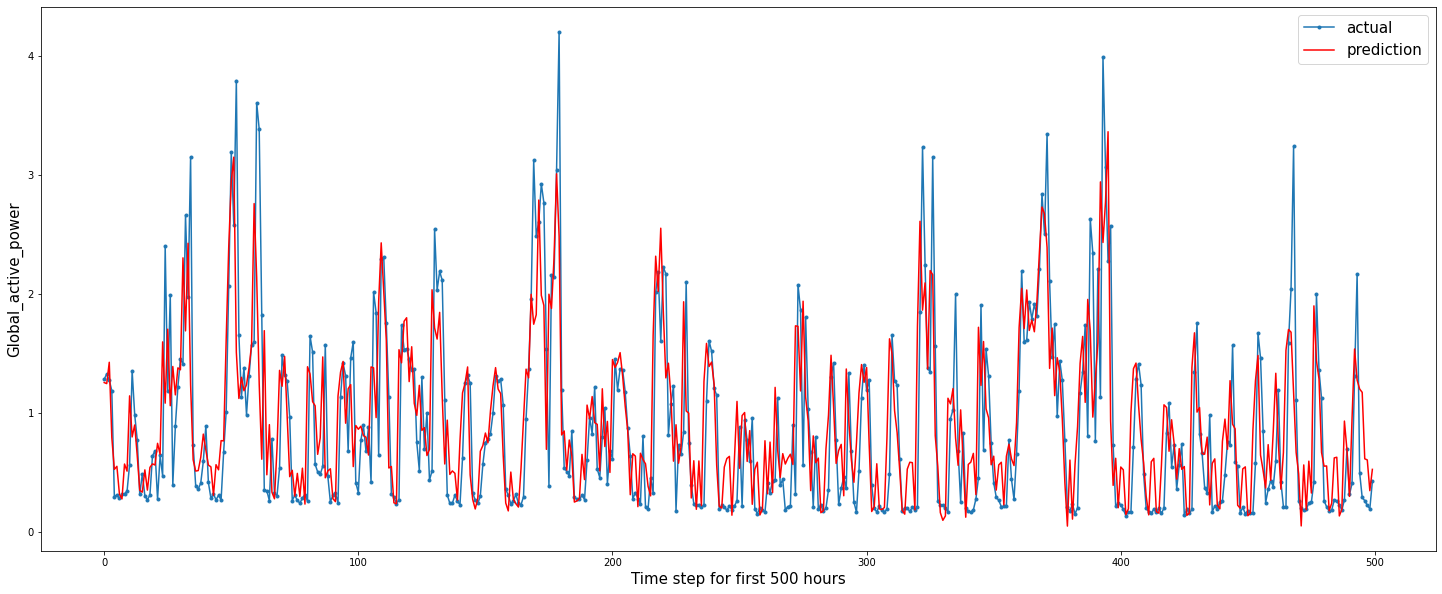

In [ ]:
size = test_x.shape[2]

# Prediction test
yhat = model.predict(test_x)
yhat = yhat.reshape((-1, 1))
print(yhat.shape)
test_x_reshape = test_x.reshape((-1, size))
print(test_x_reshape.shape)

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x_reshape[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y_reshape = test_y.reshape(-1, 1)
inv_y = np.concatenate((test_y_reshape, test_x_reshape[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

# Reference

Tensorflow 2.0 APIs
- [tf.range](https://www.tensorflow.org/api_docs/python/tf/range)
- [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd)
- [tf.keras.layers.RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
  - Also contain the example code of `return_sequences` and `return_state`
- [tf.tensordot](https://www.tensorflow.org/api_docs/python/tf/tensordot)
- [Introduction to tensor slicing](https://www.tensorflow.org/guide/tensor_slicing)

In [20]:
inv_yhat[1]

1.247712099202474

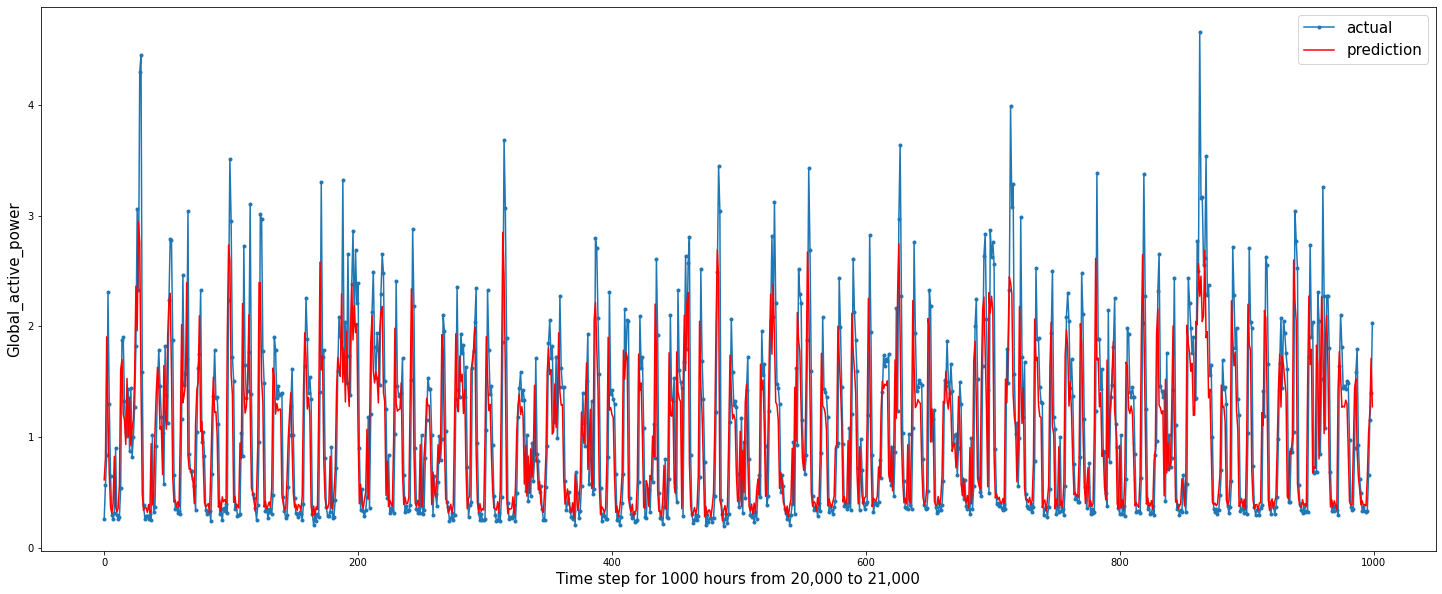

In [ ]:
aa=[x for x in range(1000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[20000:21000], marker='.', label="actual")
plt.plot(aa, inv_yhat[20000:21000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for 1000 hours from 20,000 to 21,000', size=15)
plt.legend(fontsize=15)
plt.show()

Now, let's try to fit and predict the Sub_metering_3

In [ ]:
df = df[['Sub_metering_3','Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1']]

In [ ]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/250
40/40 - 1s - loss: 0.1277 - val_loss: 0.0873
Epoch 2/250
40/40 - 1s - loss: 0.0829 - val_loss: 0.0782
Epoch 3/250
40/40 - 1s - loss: 0.0748 - val_loss: 0.0727
Epoch 4/250
40/40 - 1s - loss: 0.0706 - val_loss: 0.0703
Epoch 5/250
40/40 - 1s - loss: 0.0688 - val_loss: 0.0692
Epoch 6/250
40/40 - 1s - loss: 0.0680 - val_loss: 0.0687
Epoch 7/250
40/40 - 1s - loss: 0.0677 - val_loss: 0.0686
Epoch 8/250
40/40 - 1s - loss: 0.0672 - val_loss: 0.0686
Epoch 9/250
40/40 - 1s - loss: 0.0668 - val_loss: 0.0686
Epoch 10/250
40/40 - 1s - loss: 0.0666 - val_loss: 0.0687
Epoch 11/250
40/40 - 1s - loss: 0.0669 - val_loss: 0.0688
Epoch 12/250
40/40 - 1s - loss: 0.0666 - val_loss: 0.0689
Epoch 13/250
40/40 - 1s - loss: 0.0669 - val_loss: 0.0691
Epoch 14/250
40/40 - 1s - loss: 0.0667 - val_loss: 0.0692
Epoch 15/250
40/40 - 1s - loss: 0.0669 - val_loss: 0.0693
Epoch 16/250
40/40 - 1s - loss: 0.0665 - val_loss: 0.0694
Epoch 17/250
40/40 - 1s - loss: 0.0669 - val_loss: 0.0695
Epoch 18/250
40/40 - 1s

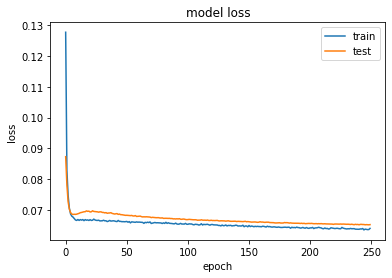

Test RMSE: 5.505


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=250, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

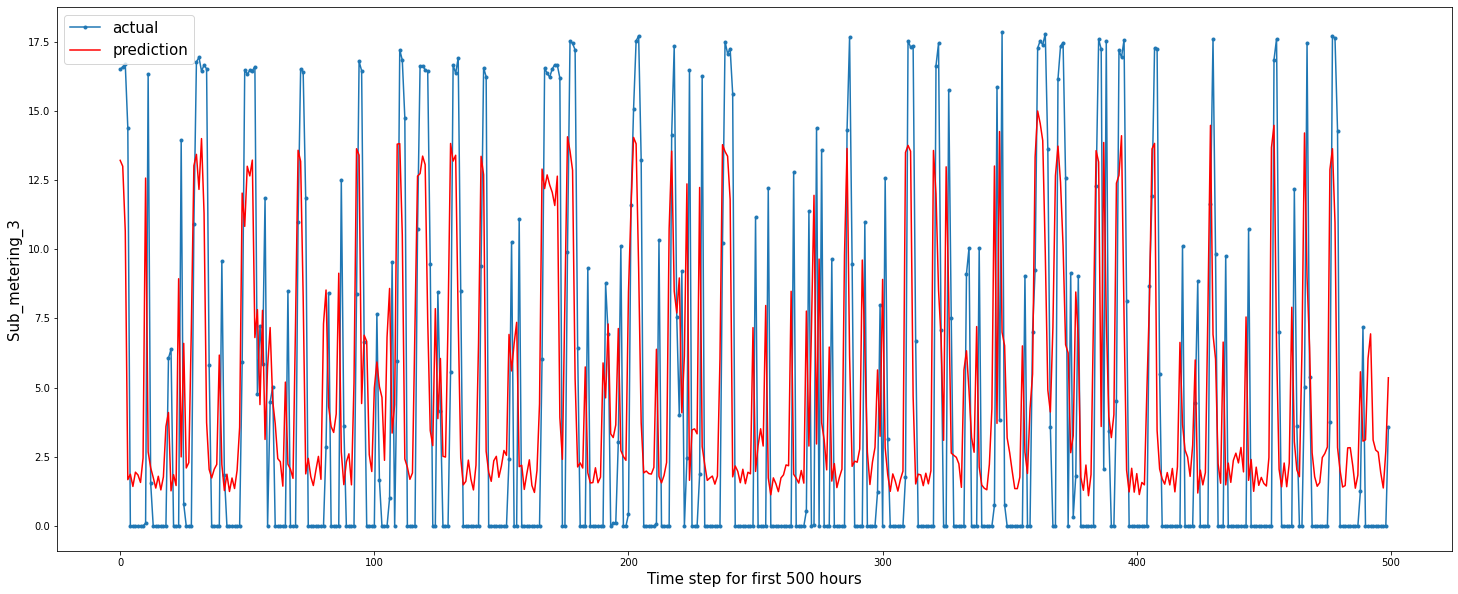

In [ ]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

Let's try to fit and predict the "Global_active_power" parameter, but this time, we do not need to include the "Voltage" data series in the database, since this is expected to NOT effect MUCH to the "Global_active_power" parameter.

In [ ]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]
df = df.drop(['Voltage'],axis=1)

In [ ]:
df.shape

(2075259, 6)

We resample as the previous procedure, and we have ONLY 6 columns in the database.

In [ ]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 6)

We also use 4000 first data points to fit the model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Epoch 1/300
40/40 - 1s - loss: 0.0315 - val_loss: 0.0117
Epoch 2/300
40/40 - 1s - loss: 0.0156 - val_loss: 0.0104
Epoch 3/300
40/40 - 1s - loss: 0.0150 - val_loss: 0.0099
Epoch 4/300
40/40 - 1s - loss: 0.0142 - val_loss: 0.0097
Epoch 5/300
40/40 - 1s - loss: 0.0138 - val_loss: 0.0095
Epoch 6/300
40/40 - 1s - loss: 0.0133 - val_loss: 0.0094
Epoch 7/300
40/40 - 1s - loss: 0.0130 - val_loss: 0.0093
Epoch 8/300
40/40 - 1s - loss: 0.0127 - val_loss: 0.0093
Epoch 9/300
40/40 - 1s - loss: 0.0125 - val_loss: 0.0093
Epoch 10/300
40/40 - 1s - loss: 0.0123 - val_loss: 0.0093
Epoch 11/300
40/40 - 1s - loss: 0.0122 - val_loss: 0.0093
Epoch 12/300
40/40 - 1s - loss: 0.0121 - val_loss: 0.0093
Epoch 13/300
40/40 - 1s - loss: 0.0121 - val_loss: 0.0093
Epoch 14/300
40/40 - 1s - loss: 0.0120 - val_loss: 0.0093
Epoch 15/300
40/40 - 1s - loss: 0.0120 - val_loss: 0.0093
Epoch 16/300
40/40 - 1s - loss: 0.0119 - val_loss: 0.0093
Epoch 17/300
40/40 - 1s - loss: 0.0119 - val_loss: 0.0093
Epoch 18/300
40/40 - 1s

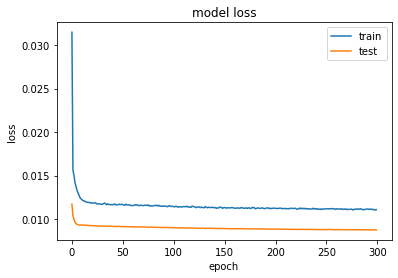

Test RMSE: 0.602


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=300, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

And compare the actual and prediction on first 500 points of the database.

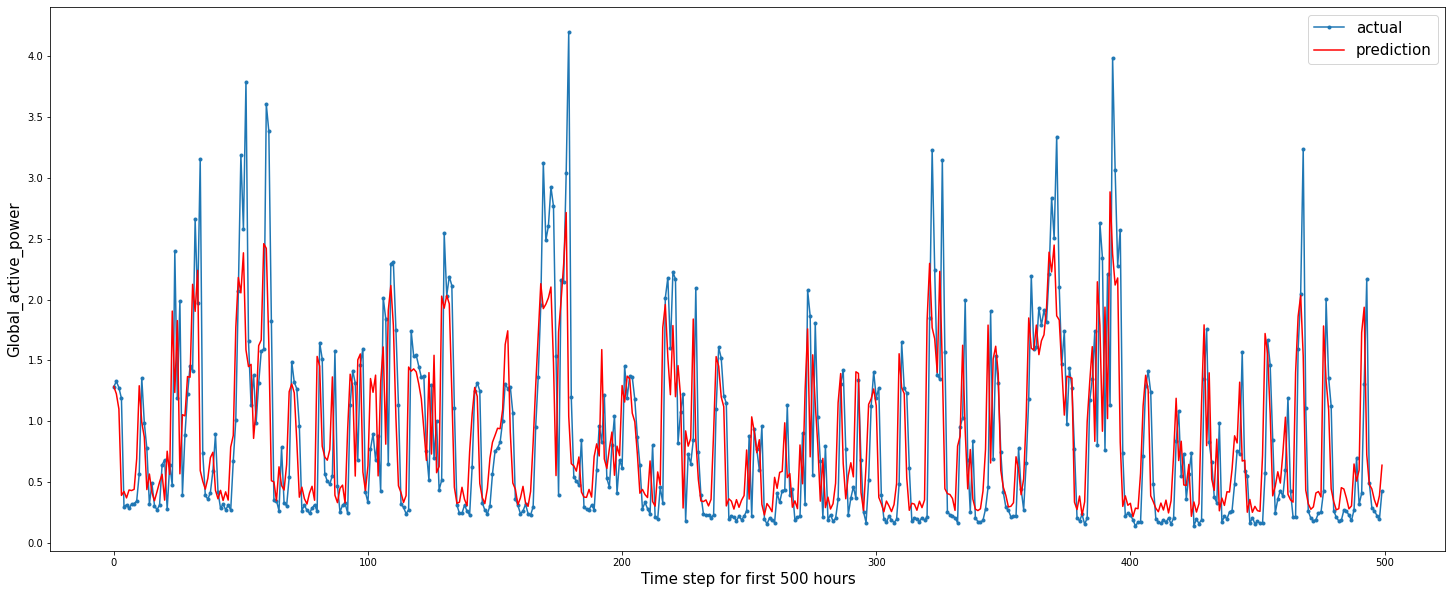

In [ ]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

NOT BAD, let check the comparison of actual and prediction on 1000 data points from the 25,000 to 26,000.

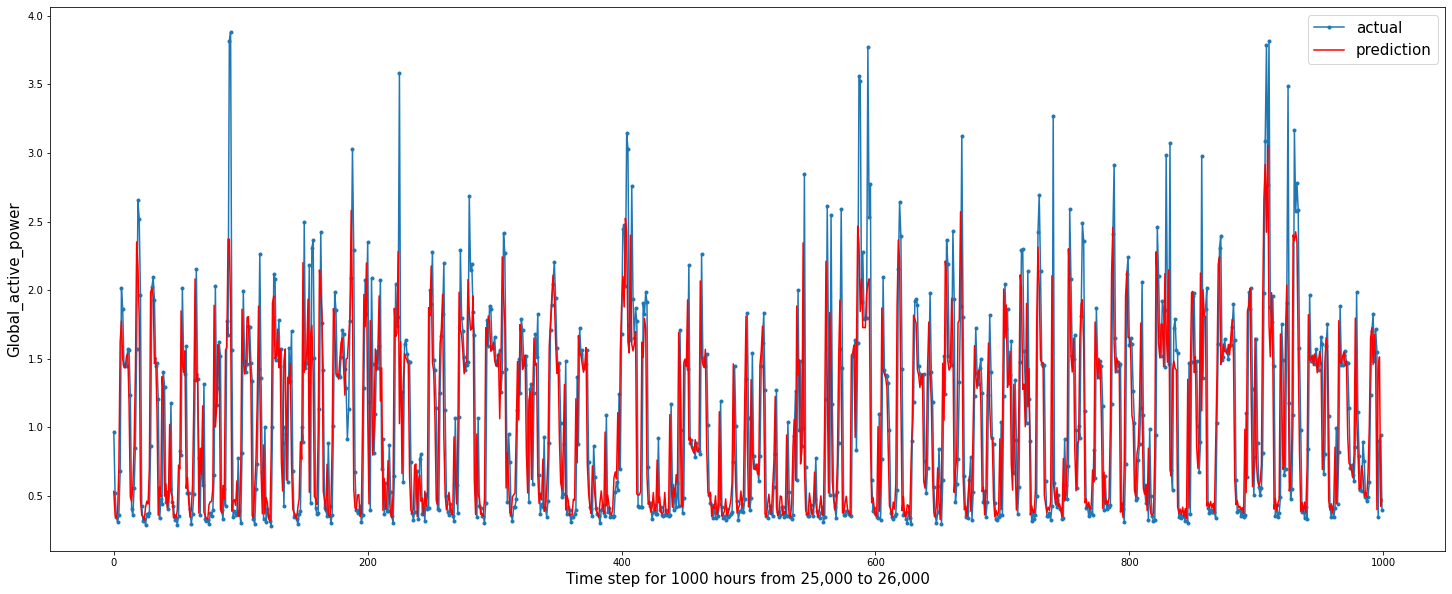

In [ ]:
aa=[x for x in range(1000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[25000:26000], marker='.', label="actual")
plt.plot(aa, inv_yhat[25000:26000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for 1000 hours from 25,000 to 26,000', size=15)
plt.legend(fontsize=15)
plt.show()

<h3> Conclusions<h3>

In this Notebook, I practice to use the LSTM to fit and predict household electric power consumption. 

+ Consideration of the amount of input data is important to balance model accuracy and computation cost.

+ The database can be used 30% for fitting purposes and the rest can be used to validate the model.